# Using OpenCV to Identify Lane Lines on Driving Input Video
### Project 1 of Udacity Self-Driving Vehicle Nano-Degree
---

### Import Required External Libraries

In [1]:
# Import libraries
import matplotlib.pyplot as plt          # Plotting data in Jupyter
import matplotlib.image as mpimg         # Image manipulation library such as read/display
import numpy as np                       # Numerical Python - Used for for matrices and other math operations
import cv2                               # Core library used to manipulate input data and generate output
from moviepy.editor import VideoFileClip # To display videos in HTML
from IPython.display import HTML         # To display videos

%matplotlib inline

### Define Static Strings

In [2]:
# Input static variables *not truly static, doesn't exist in python
test_image_file_path = 'input/images/solidWhiteRight.jpg'
input_images_dir_path = 'input/images/'
input_videos_dir_path = 'input/videos/'

output_images_dir_path = 'output/images/'
output_videos_dir_path = 'output/videos/'

white_output = output_videos_dir_path + 'solidWhiteRight.mp4'
yellow_output = output_videos_dir_path + 'solidYellowLeft.mp4'

### Load a Test Image

Test image type:  <class 'numpy.ndarray'>
Test image array shape:  (540, 960, 3)


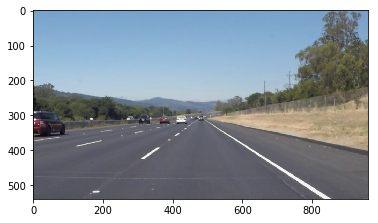

In [3]:
# Load test image into memory
test_image = mpimg.imread(test_image_file_path)

# Analyze test image
print('Test image type: ', type(test_image))
print('Test image array shape: ', test_image.shape)

# Display test image
plt.imshow(test_image)

## Define Standard Functions

In [4]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    left_total_slope = 0
    left_total_intersect = 0
    left_lines_count = 0
    right_total_slope = 0
    right_total_intersect = 0
    right_lines_count = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intersect = y1 - (slope*x1)
            if slope < 0:
                left_total_slope = left_total_slope + slope
                left_total_intersect = left_total_intersect + intersect
                left_lines_count = left_lines_count + 1
            else:
                right_total_slope = right_total_slope + slope
                right_total_intersect = right_total_intersect + intersect
                right_lines_count = right_lines_count + 1

    if left_lines_count > 0:
        left_avg_slope = left_total_slope/left_lines_count
        left_avg_intersect = int(left_total_intersect/left_lines_count)
        cv2.line(img, (int((540-left_avg_intersect)/left_avg_slope), 540), (int((320-left_avg_intersect)/left_avg_slope), 320), [0, 255, 0], 10)
    if right_lines_count > 0:
        right_avg_slope = right_total_slope/right_lines_count
        right_avg_intersect = int(right_total_intersect/right_lines_count)
        cv2.line(img, (int((540-right_avg_intersect)/right_avg_slope), 540), (int((320-right_avg_intersect)/right_avg_slope), 320), [0, 255, 0], 10)
  
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

In [5]:
import os
os.listdir(input_images_dir_path)

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Lane Finding Pipeline

Image solidYellowCurve.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Image solidYellowLeft.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Image solidYellowCurve2.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Image solidWhiteRight.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Image whiteCarLaneSwitch.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Image solidWhiteCurve.jpg is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


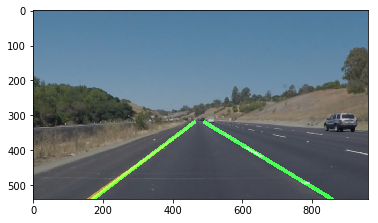

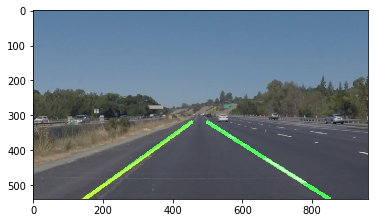

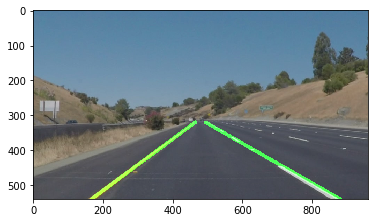

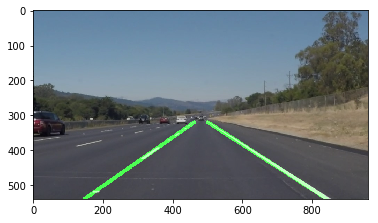

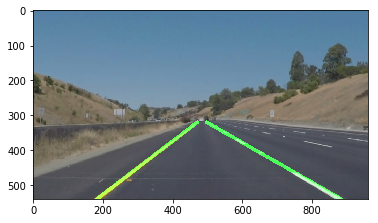

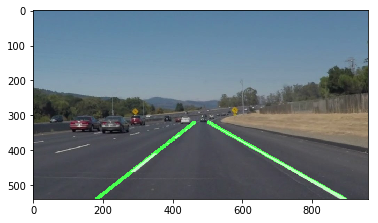

In [6]:
images = os.listdir(input_images_dir_path)

for image_name in images:
    image = mpimg.imread(input_images_dir_path + image_name)
    print('Image',image_name, 'is:', type(image), 'with dimensions:', image.shape)
    gray = grayscale(image)
    cv2.imwrite(output_images_dir_path + '/grayscale/' + image_name, gray)
    grayblur = gaussian_blur(gray,3)
    edges = canny(grayblur, 120, 240)
    cv2.imwrite(output_images_dir_path + '/edges/' + image_name, edges)
    region = region_of_interest(edges, np.array([[[50,540],[420,320],[550,320],[960,540]]]))
    cv2.imwrite(output_images_dir_path + '/region/' + image_name, region)
    weighted = weighted_img(hough_lines(region, 1, np.pi/180, 30, 5, 10), image, α=0.8, β=1., λ=0.)
    cv2.imwrite(output_images_dir_path + '/weighted/' + image_name, cv2.cvtColor(weighted, cv2.COLOR_RGB2BGR))
    plt.figure()
    plt.imshow(weighted, cmap='gray')

In [7]:
def process_image(image):
    gray = grayscale(image)
    grayblur = gaussian_blur(gray,3)
    edges = canny(grayblur, 120, 240)
    region = region_of_interest(edges, np.array([[[100,540],[420,340],[550,340],[850,540]]]))
    return weighted_img(hough_lines(region, 1, np.pi/180, 30, 5, 10), image, α=0.8, β=1., λ=0.)

In [8]:
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
clip1 = VideoFileClip(input_videos_dir_path + "solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output/videos/solidWhiteRight.mp4
[MoviePy] Writing video output/videos/solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:01<00:00, 103.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/videos/solidWhiteRight.mp4 

CPU times: user 1.38 s, sys: 295 ms, total: 1.67 s
Wall time: 1.54 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
clip2 = VideoFileClip(input_videos_dir_path + "solidYellowLeft.mp4").subclip(0,3)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video output/videos/solidYellowLeft.mp4
[MoviePy] Writing video output/videos/solidYellowLeft.mp4


 99%|█████████▊| 75/76 [00:00<00:00, 107.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/videos/solidYellowLeft.mp4 

CPU times: user 811 ms, sys: 194 ms, total: 1.01 s
Wall time: 1.03 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))